# Trabajo Práctico ACN
## Simulación Molino de Viento

La empresa tiene dos molinos de viento en Patagonia, a cierta distancia entre sí. Llamamos a uno molino Norte y al otro molino Sur. Para el viento promedio (espacial) de la región en cada día \(i\) considerará que el siguiente modelo representa bien la realidad:

$$
S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_i
$$

con $\Delta = 1/365$ y la media estacional

$$
\theta(t_i) = 6 + 2 \cos\left(\frac{2\pi i}{365}\right)
$$

El reloj \(t_i\) corre en frecuencia diaria y el shock \(Z\) es una variable normal estándar (media = 0, std dev = 1) e independiente entre días consecutivos.

La diferencia de viento entre el molino Norte y el molino Sur es cero el primer día y luego evoluciona como

$$
D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_i
$$

donde los shocks \(W\) son shocks normalmente distribuidos e independientes de los shocks \(Z\) que impulsan al viento regional.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Cargamos los datos del viento

In [5]:
viento = pd.read_excel('WindData.xlsx')
viento

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442
...,...,...,...
3645,3646,8.642231,-0.869425
3646,3647,6.527408,-1.268447
3647,3648,6.230707,-1.149234
3648,3649,5.550882,-0.420431


In [14]:
delta = 1/365
#Si+1 - Si = k(theta - si)delta + sigma*raiz(delta)*shock
# Si+1 - Si = Yi
# (theta-si)delta = Xi
# sigma*raiz(delta) = c

#Regresion lineal
## Yi = k*Xi + c*Zi --> Zi ~ N(0, c**2)

theta = 6 + 2 * np.cos(2 * np.pi * np.array(range(3649)) / 365)


Y = (viento["regional wind"][1:]-viento["regional wind"].shift(1)[1:]).values
X = ((theta - viento["regional wind"][:-1])*delta).values

regresion = LinearRegression().fit(X.reshape(-1,1), Y)
Y_pred = regresion.predict(X.reshape(-1,1))
error = Y-Y_pred
c = error.var()
S_0 = viento["regional wind"].iloc[0]
kappa = regresion.coef_[0]
# theta = viento["regional wind"].mean()
sigma = np.sqrt(c/delta)


In [15]:
print(kappa,sigma,theta)


109.25679788838752 16.043719733423078 [8.         7.99970368 7.9988148  ... 7.99526061 7.99733363 7.9988148 ]


In [17]:

# Parámetro delta
delta = 1/365

# Definición de Y e X
Y = (viento["wind gap norte sur"][1:] - viento["wind gap norte sur"].shift(1)[1:]).values
X = (-viento["wind gap norte sur"][:-1] * delta).values

# Ajuste del modelo de regresión lineal
regresion = LinearRegression().fit(X.reshape(-1, 1), Y)
Y_pred = regresion.predict(X.reshape(-1, 1))

# Error y varianza
error = Y - Y_pred
c = error.var()

# Estimación de los parámetros
beta = -regresion.coef_[0]  # Cambiamos el signo porque en la ecuación original es -beta
gamma = np.sqrt(c / delta)

# Resultados
print("Estimación de beta:", beta)
print("Estimación de gamma:", gamma)


Estimación de beta: -48.37733323194366
Estimación de gamma: 10.09071995713833


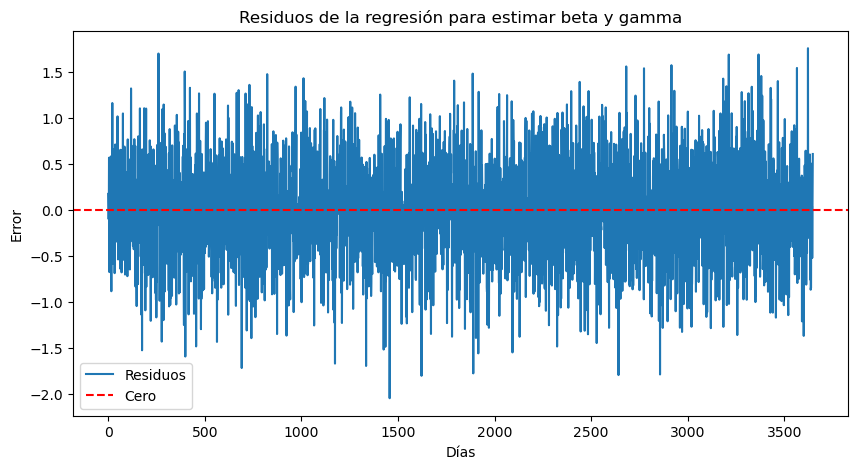

In [18]:
import matplotlib.pyplot as plt

# Gráfico de residuos
plt.figure(figsize=(10, 5))
plt.plot(error, label='Residuos')
plt.axhline(0, color='red', linestyle='--', label='Cero')
plt.xlabel('Días')
plt.ylabel('Error')
plt.title('Residuos de la regresión para estimar beta y gamma')
plt.legend()
plt.show()


In [20]:
error.mean()

2.434032391614484e-18

In [35]:
def viento_paths(S_0, kappa, theta, sigma, delta, T, m):
    S = np.zeros(m, T)
    S[:,0] = S_0
    for t in range(1, T):
        S[:, t] = S[:, t-1] + kappa (theta[t] - S[:,t-1]) 
        delta + np.sqrt(delta * np.random.normal(0,1,m) * sigma)
    return S


In [38]:
#grafico emi
S_0 = viento["regional wind"].iloc[0]
m = 1000
T = 365*1 # simulamos los 34 años
S = viento_paths(S_0, kappa, theta, sigma,delta, T, m)

plt.figure(figsize=(10, 6))
plt.plot(S[0], label='Simulated data')
plt.plot(viento["regional wind"].values, label='Real data')
plt.hlines(theta, 0, S[0].shape[0], colors='r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Porn prices')
plt.legend()
plt.show()

TypeError: Cannot interpret '365' as a data type

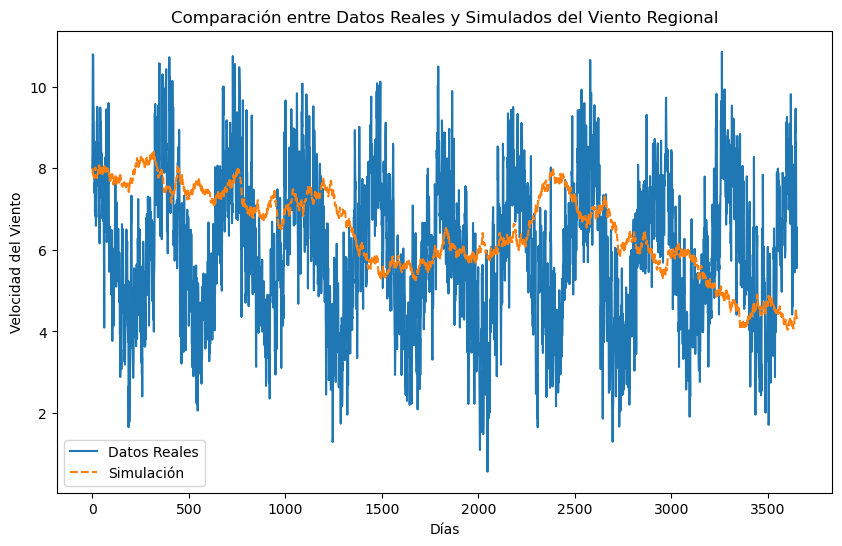

In [44]:
#grafico chatty
# Función ajustada para simular los caminos del viento
def viento_paths(S_0, kappa, theta, delta, T, m, sigma):
    S = np.zeros((m, T))
    S[:, 0] = S_0
    for t in range(1, T):
        S[:, t] = S[:, t-1] + kappa * (theta[t] - S[:, t-1]) * delta + np.sqrt(delta) * sigma * np.random.normal(0, 1, m)
    return S

# Parámetros de entrada
S_0 = 8  # Valor inicial del viento regional del dataset
#kappa = 0.1  # Este valor es un ejemplo, deberías usar el estimado
#sigma = 1  # Este valor es un ejemplo, deberías usar el estimado
T = len(viento)  # Número total de días (T)
m = 100000  # Número de simulaciones (en este caso 1)

# Theta calculado a partir de la fórmula dada
theta = 6 + 2 * np.cos(2 * np.pi * np.arange(T) / 365)

# Simulación del viento
S_simulado = viento_paths(S_0, kappa, theta, delta, T, m, sigma)[0]  # Tomamos la primera simulación

# Comparación gráfica entre los datos simulados y reales
plt.figure(figsize=(10, 6))
plt.plot(viento["regional wind"], label='Datos Reales')
plt.plot(S_simulado, label='Simulación', linestyle='--')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento')
plt.title('Comparación entre Datos Reales y Simulados del Viento Regional')
plt.legend()
plt.show()


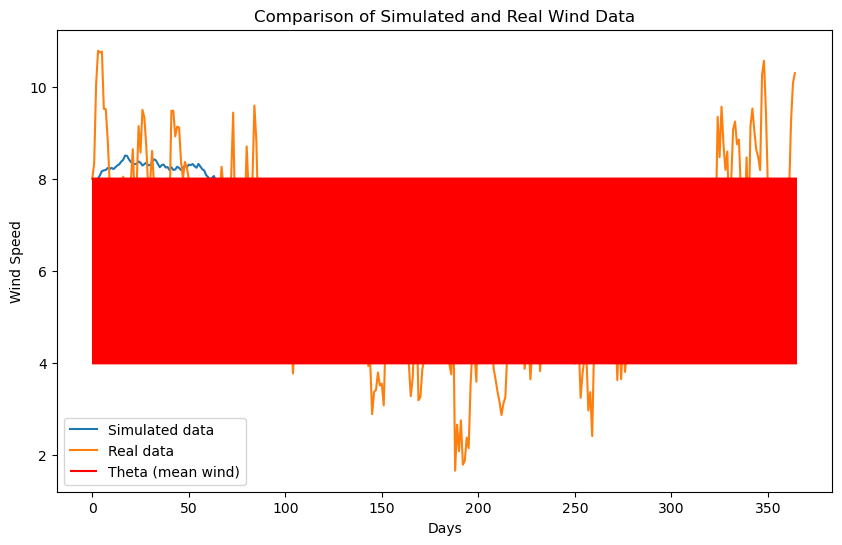

In [39]:
# Función corregida para simular los caminos del viento
def viento_paths(S_0, kappa, theta, sigma, delta, T, m):
    S = np.zeros((m, T))  # Corregimos la creación de la matriz
    S[:, 0] = S_0
    for t in range(1, T):
        S[:, t] = S[:, t-1] + kappa * (theta[t] - S[:, t-1]) * delta + np.sqrt(delta) * sigma * np.random.normal(0, 1, m)
    return S

# Parámetros de entrada
S_0 = viento["regional wind"].iloc[0]
m = 1000  # Número de simulaciones
T = 365  # Simulación de 1 año (ajusta según sea necesario)
delta = 1/365  # Paso de tiempo

# Theta calculado a partir de la fórmula dada
theta = 6 + 2 * np.cos(2 * np.pi * np.arange(T) / 365)

# Simulación del viento
S = viento_paths(S_0, kappa, theta, sigma, delta, T, m)

# Comparación gráfica entre los datos simulados y reales
plt.figure(figsize=(10, 6))
plt.plot(S[0], label='Simulated data')  # Primera simulación
plt.plot(viento["regional wind"].values[:T], label='Real data')  # Datos reales
plt.hlines(theta, 0, T, colors='r', label='Theta (mean wind)')
plt.xlabel('Days')
plt.ylabel('Wind Speed')
plt.title('Comparison of Simulated and Real Wind Data')
plt.legend()
plt.show()


In [45]:
S = sample_S(S_0, mu, sigma, delta, 21,100)
for S_i in S:
    plt.plot(S_i)

plt.show()

NameError: name 'sample_S' is not defined